
# SVM on BRFSS Diabetes Data (Imbalanced)

This notebook trains a Support Vector Machine on the imbalanced BRFSS diabetes dataset (`archive/diabetes_binary_health_indicators_BRFSS2015.csv`), performs exploratory data analysis, and tunes hyperparameters with grid search while reweighting classes.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')



## Load data
We use the non-50/50 split dataset so that the natural class imbalance is preserved.


In [2]:

DATA_PATH = Path("archive/diabetes_binary_health_indicators_BRFSS2015.csv")
df = pd.read_csv(DATA_PATH)

print(f"Shape: {df.shape}")
df.head()


Shape: (253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0



## Exploratory data analysis
Check class balance, missingness, and feature correlations with the diabetes indicator.


Class counts: Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64
Class proportions: Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64


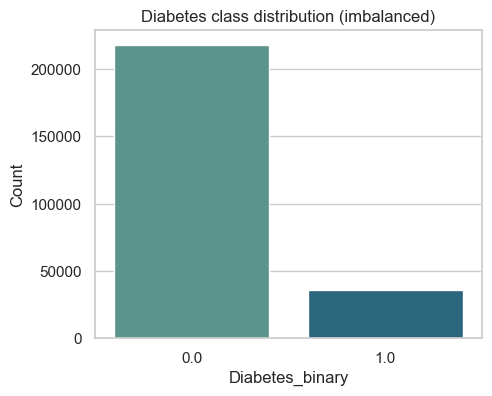

In [3]:

# Target distribution
class_counts = df['Diabetes_binary'].value_counts()
class_props = df['Diabetes_binary'].value_counts(normalize=True)
print("Class counts:", class_counts)
print("Class proportions:", class_props)

fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest", ax=ax)
ax.set_title("Diabetes class distribution (imbalanced)")
ax.set_xlabel("Diabetes_binary")
ax.set_ylabel("Count")
plt.show()


In [4]:

# Missing values and basic stats
missing = df.isnull().sum()
print("Missing values per column:", missing)

summary = df.describe().T
summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]


Missing values per column: Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


,mean,std,min,25%,50%,75%,max
Diabetes_binary,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


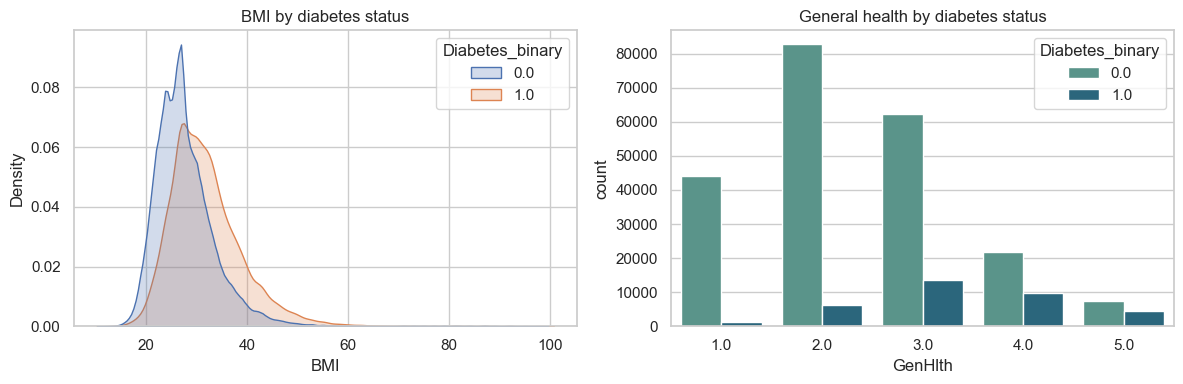

In [5]:

# Example feature distributions by class
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(data=df, x='BMI', hue='Diabetes_binary', fill=True, common_norm=False, ax=axes[0])
axes[0].set_title('BMI by diabetes status')

sns.countplot(data=df, x='GenHlth', hue='Diabetes_binary', palette='crest', ax=axes[1])
axes[1].set_title('General health by diabetes status')
axes[1].legend(title='Diabetes_binary')
plt.tight_layout()
plt.show()



## Modeling with class-weighted SVM
We standardize features, apply a linear SVM with `class_weight='balanced'`, and tune the regularization strength using grid search scored by ROC-AUC. Stratified splits preserve the original imbalance.


In [6]:

X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(class_weight="balanced", max_iter=5000)),
])

param_grid = {
    "linear_svc__C": [0.01, 0.1, 1.0, 10.0],
    "linear_svc__loss": ["squared_hinge"],
    "linear_svc__dual": [False],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# n_jobs=1 avoids OS semaphore limits in some sandboxed environments
search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
    verbose=1,
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'linear_svc__C': 0.01, 'linear_svc__dual': False, 'linear_svc__loss': 'squared_hinge'}
Best CV ROC-AUC: 0.822945344769229


Test metrics:
roc_auc: 0.8194
accuracy: 0.7274
precision: 0.3082
recall: 0.7686
f1: 0.4400
Confusion matrix: [[31472 12195]
 [ 1636  5433]]
Classification report:               precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     43667
         1.0       0.31      0.77      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736



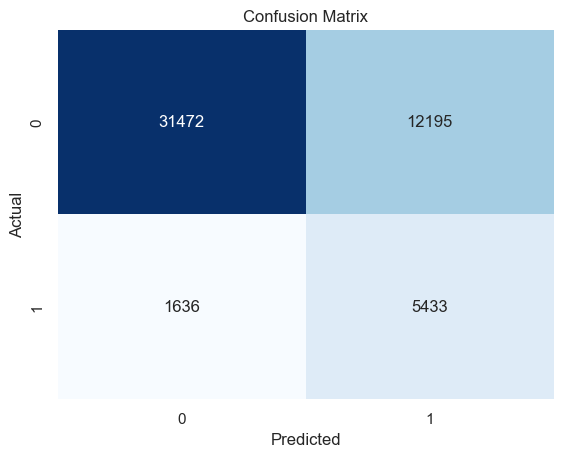

In [7]:
# Evaluate on hold-out test set
best_model = search.best_estimator_
probs = best_model.decision_function(X_test)
preds = best_model.predict(X_test)

metrics = {
    "roc_auc": roc_auc_score(y_test, probs),
    "accuracy": accuracy_score(y_test, preds),
    "precision": precision_score(y_test, preds),
    "recall": recall_score(y_test, preds),
    "f1": f1_score(y_test, preds),
}

print("Test metrics:")
for name, val in metrics.items():
    print(f"{name}: {val:.4f}")

cm = confusion_matrix(y_test, preds)
print("Confusion matrix:", cm)
print("Classification report:", classification_report(y_test, preds))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Correlation heatmap
Feature relationships for the imbalanced dataset.

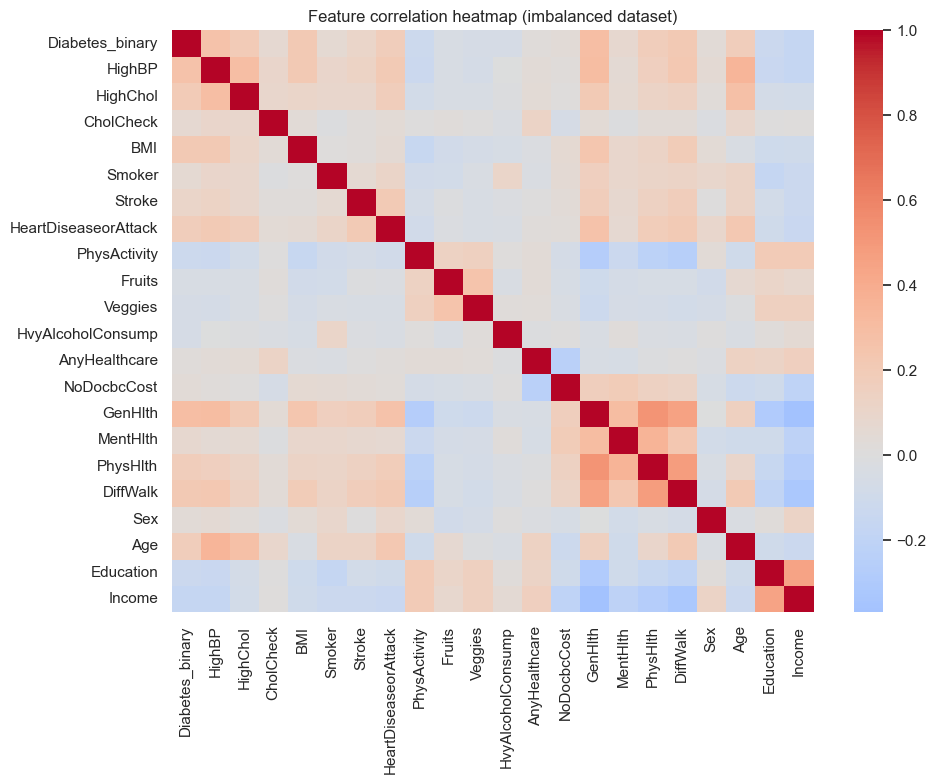

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature correlation heatmap (imbalanced dataset)')
plt.tight_layout()
plt.show()

## Threshold sweep and metrics

Best threshold by F1 on test scores: 0.2226


,setting,threshold,accuracy,precision,recall,f1,roc_auc
0,Default (0),0.00000,0.727393,0.308203,0.768567,0.439972,0.81942
1,Tuned,0.22264,0.801758,0.369419,0.598104,0.456735,0.81942


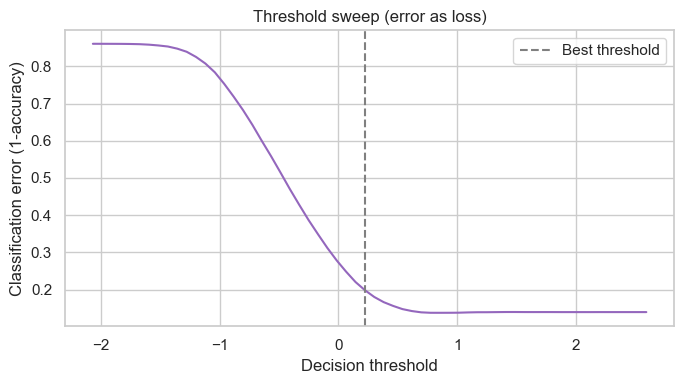

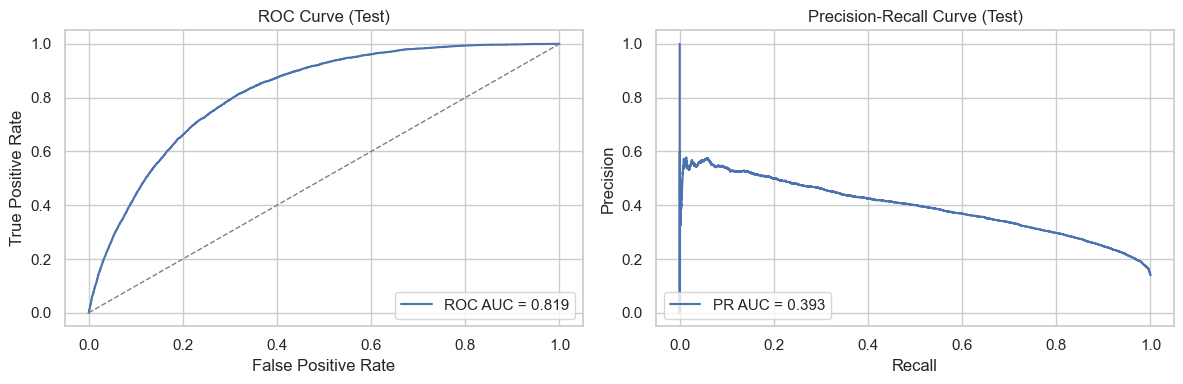

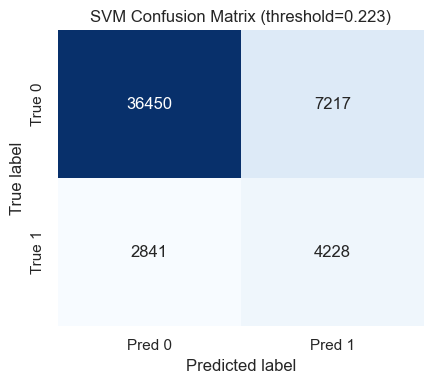

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

thresholds = np.linspace(probs.min(), probs.max(), 60)
records = []
for t in thresholds:
    preds_t = (probs >= t).astype(int)
    records.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, preds_t),
        "precision": precision_score(y_test, preds_t, zero_division=0),
        "recall": recall_score(y_test, preds_t, zero_division=0),
        "f1": f1_score(y_test, preds_t, zero_division=0),
    })

metrics_df = pd.DataFrame(records)
best_row = metrics_df.loc[metrics_df['f1'].idxmax()]
best_threshold = float(best_row['threshold'])
print(f"Best threshold by F1 on test scores: {best_threshold:.4f}")

summary = pd.DataFrame([
    {
        "setting": "Default (0)",
        "threshold": 0.0,
        "accuracy": metrics['accuracy'],
        "precision": metrics['precision'],
        "recall": metrics['recall'],
        "f1": metrics['f1'],
        "roc_auc": metrics['roc_auc'],
    },
    {
        "setting": "Tuned",
        "threshold": best_threshold,
        "accuracy": best_row['accuracy'],
        "precision": best_row['precision'],
        "recall": best_row['recall'],
        "f1": best_row['f1'],
        "roc_auc": roc_auc_score(y_test, probs),
    },
])

display(summary)

# Loss-style curve: classification error vs decision threshold
plt.figure(figsize=(7, 4))
plt.plot(metrics_df['threshold'], 1 - metrics_df['accuracy'], color='tab:purple')
plt.axvline(best_threshold, color='gray', linestyle='--', label='Best threshold')
plt.xlabel('Decision threshold')
plt.ylabel('Classification error (1-accuracy)')
plt.title('Threshold sweep (error as loss)')
plt.legend()
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, probs)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall_curve, precision_curve)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
ax[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
ax[0].set_title('ROC Curve (Test)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

ax[1].plot(recall_curve, precision_curve, label=f"PR AUC = {pr_auc:.3f}")
ax[1].set_title('Precision-Recall Curve (Test)')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='lower left')
plt.tight_layout()
plt.show()

cm_tuned = confusion_matrix(y_test, (probs >= best_threshold).astype(int))
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title(f'SVM Confusion Matrix (threshold={best_threshold:.3f})')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()